 ### 0.0 Load modules

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

ModuleNotFoundError: No module named 'lime'

In [ ]:
!pip install shap

     |████████████████████████████████| 273 kB 333 kB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-linux_x86_64.whl size=399340 sha256=9ec7a112728ff334d006ba49c82cbb19fde87c47891b3efef5b22b833d57f55d
  Stored in directory: /home/paras/.cache/pip/wheels/c3/e0/82/26cebc699e23c6a1b9963981e1a10ed7de75db012f4af12428
Successfully built shap


### 0.1 Load data

In [2]:
Combined_data = pd.read_csv('AB_NYC_2019.csv')
Combined_data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [3]:
print('Number of features: {}'.format(Combined_data.shape[1]))
print('Number of examples: {}'.format(Combined_data.shape[0]))

Number of features: 16
Number of examples: 48895


In [4]:
#for c in df.columns:
#    print(c, dtype(df_train[c]))
Combined_data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
Combined_data['last_review'] = pd.to_datetime(Combined_data['last_review'],infer_datetime_format=True) 

# 1. Preprocessing and EDA

## 1.0 Missing data

Many machine learning algorithms do badly when acting on inputs with missing data. To deal with this, we start by taking a count of missing values in each column.

In [6]:
total = Combined_data.isnull().sum().sort_values(ascending=False)
percent = (Combined_data.isnull().sum())/Combined_data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

Total   Percent
reviews_per_month               10052  0.205583
last_review                     10052  0.205583
host_name                          21  0.000429
name                               16  0.000327
availability_365                    0  0.000000
calculated_host_listings_count      0  0.000000
number_of_reviews                   0  0.000000
minimum_nights                      0  0.000000
price                               0  0.000000
room_type                           0  0.000000
longitude                           0  0.000000
latitude                            0  0.000000
neighbourhood                       0  0.000000
neighbourhood_group                 0  0.000000
host_id                             0  0.000000
id                                  0  0.000000

In [7]:
Combined_data.drop(['host_name','name'], axis=1, inplace=True)

In [8]:
Combined_data[Combined_data['number_of_reviews']== 0.0].shape

(10052, 14)

The NaN values in the last_review and reviews_per_month columns all occur for examples where no reviews were given in the first place. 

For reviews_per_month, I will fill those values with 0's.

In [9]:
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

In [10]:
earliest = min(Combined_data['last_review'])
Combined_data['last_review'] = Combined_data['last_review'].fillna(earliest)
Combined_data['last_review'] = Combined_data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [11]:
total = Combined_data.isnull().sum().sort_values(ascending=False)
percent = (Combined_data.isnull().sum())/Combined_data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

Total  Percent
availability_365                    0      0.0
calculated_host_listings_count      0      0.0
reviews_per_month                   0      0.0
last_review                         0      0.0
number_of_reviews                   0      0.0
minimum_nights                      0      0.0
price                               0      0.0
room_type                           0      0.0
longitude                           0      0.0
latitude                            0      0.0
neighbourhood                       0      0.0
neighbourhood_group                 0      0.0
host_id                             0      0.0
id                                  0      0.0

## 1.2 Choosing a prediction target [Smart Pricing Regressor]

One of the machine learning models at AirBNB is Smart Pricing. After a client has entered the details of their rental, AirBNB suggests an appropriate price. The aim of this notebook is to build and train a Smart Pricing model for this dataset.

## 1.3 Price distribution

I notice that the target has a highly skewed distribution. This can cause problems for machine learning algorithms such as linear regression. A log transformation and removal of outliers makes the distribution look much closer to normal.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


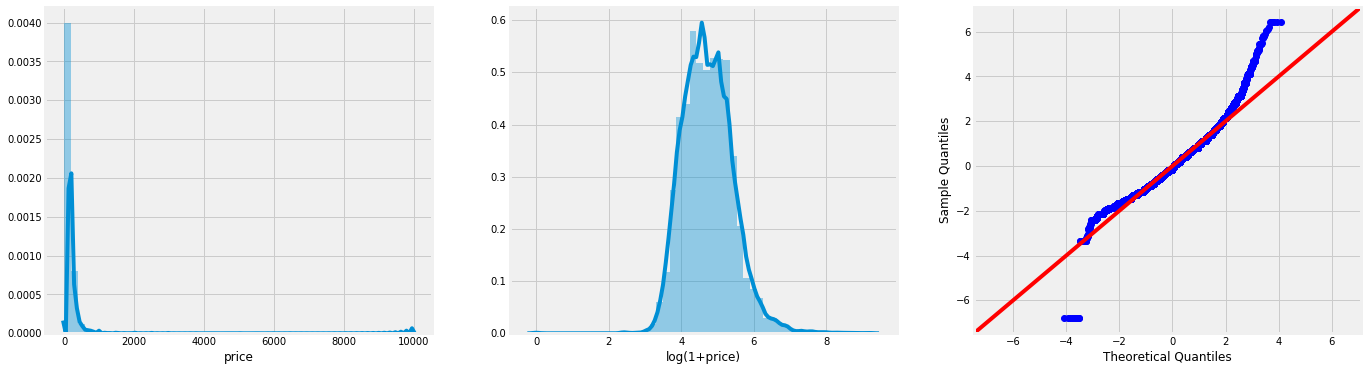

In [12]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['price'], ax=axes[0])
sns.distplot(np.log1p(Combined_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [13]:
Combined_data = Combined_data[np.log1p(Combined_data['price']) < 8]
Combined_data = Combined_data[np.log1p(Combined_data['price']) > 3]

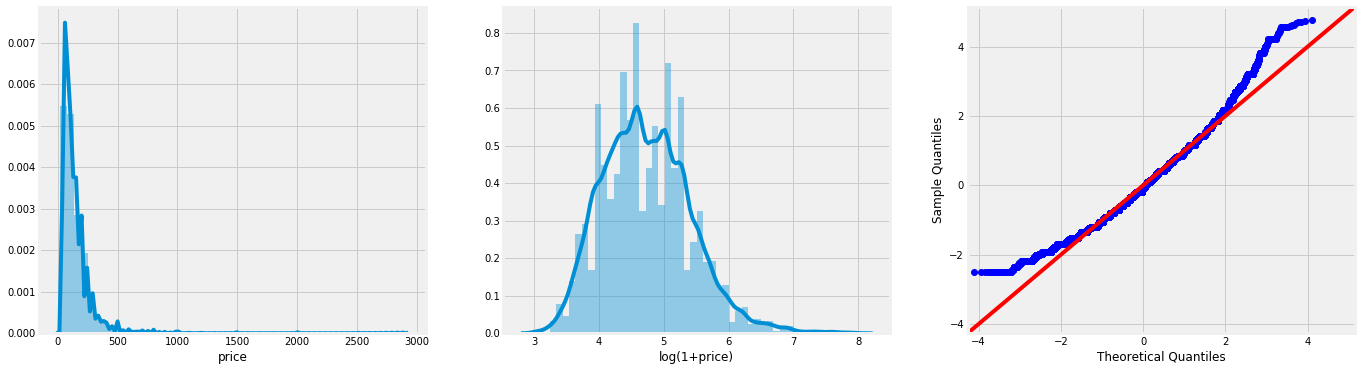

In [14]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['price'], ax=axes[0])
sns.distplot(np.log1p(Combined_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [15]:
Combined_data['price'] = np.log1p(Combined_data['price'])

## 1.4. Predictor distributions

### 1.4.0 A list of predictors

In [16]:
print(Combined_data.columns)

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


### 1.4.1 Host_id

In [17]:
print('In this dataset there are {} unique hosts renting out  a total number of {} properties.'.format(len(Combined_data['host_id'].unique()), Combined_data.shape[0]))

In this dataset there are 37384 unique hosts renting out  a total number of 48784 properties.


Since the number of unique hosts is close to the total number of examples, we're not going to use hostname in our regression analysis since it would cause the number of parameters in our model to baloon! 

In real-life, when there is more data and perhaps some feature data on hosts, I expect past history of a host and of a property to be a strong predictor of price!

In [18]:
Combined_data = Combined_data.drop(['host_id', 'id'], axis=1)

### 1.4.2 Neighbourhood group

I notice that Statten Island and the Bronx are highly underrepresented in this dataset. For Statten Island, the reason is that the population of the island is small. However, this can't be the case for the Bronx which has a population comparable (~1.4mln) to Manhattan (~1.6mln) or for for Brooklyn /Queens with their populations of ~2.5mln and ~2.4mln, respectively. 

This makes sense: Queens, the Bronx  and, to a fair extent Brooklyn, are residential neighborhoods unlike Manhattan which is a business centre as well as a tourist destination.

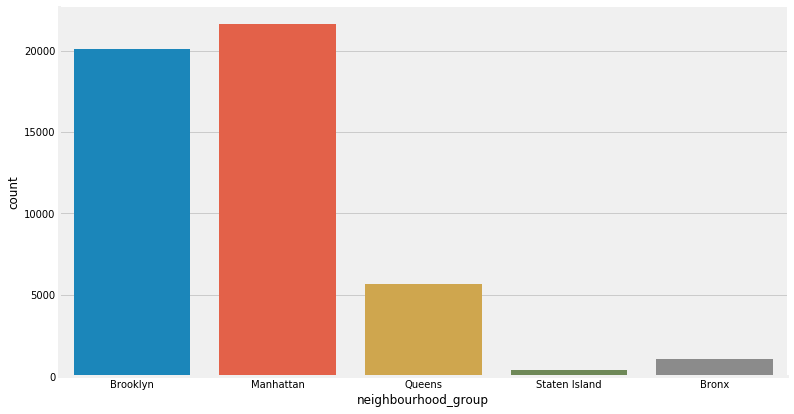

In [19]:
sns.catplot(x='neighbourhood_group', kind='count' ,data=Combined_data)
fig = plt.gcf()
fig.set_size_inches(12, 6)

### 1.4.3 Longitude and latitude

Longitude and latitude are somewhat correlated with each other. This is because the locations of properties tend to come from clusters.

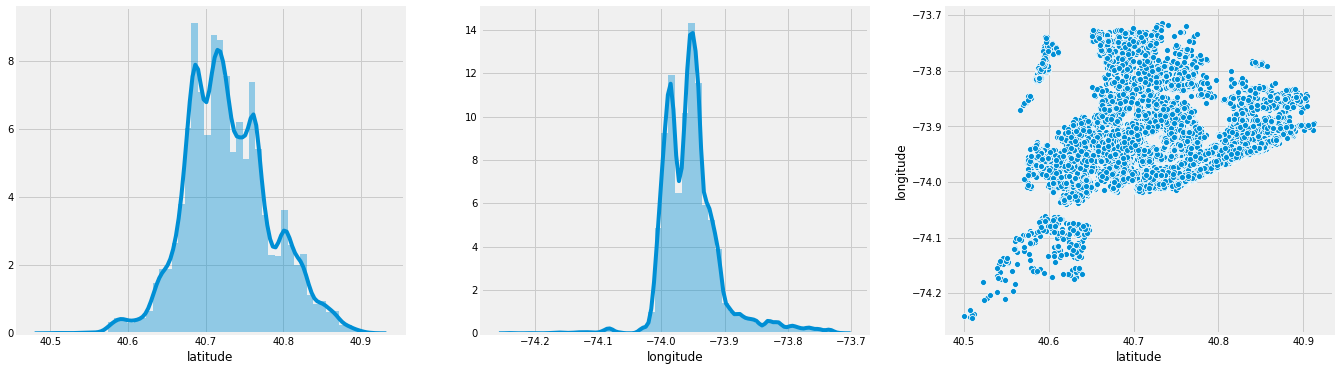

In [20]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['latitude'], ax=axes[0])
sns.distplot(Combined_data['longitude'], ax=axes[1])
sns.scatterplot(x= Combined_data['latitude'], y=Combined_data['longitude'])

### 1.4.4 Room type

As far as room types, this dataset is balanced away from 'Shared room' properties. The proportions of private room and entire home/apt rentals are close, with entire home/apt dominating prive room by <10%.

In [21]:
sns.catplot(x='room_type', kind='count' ,data=Combined_data)
fig = plt.gcf()
fig.set_size_inches(8, 6)

### 1.4.5 Minimum nights

In [22]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(Combined_data['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(Combined_data['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

Text(0, 0.5, 'count')

In [23]:
Combined_data['minimum_nights'] = np.log1p(Combined_data['minimum_nights'])

### 1.4.6 Reviews per month

Text(0.5, 0, 'ln(reviews_per_month)')

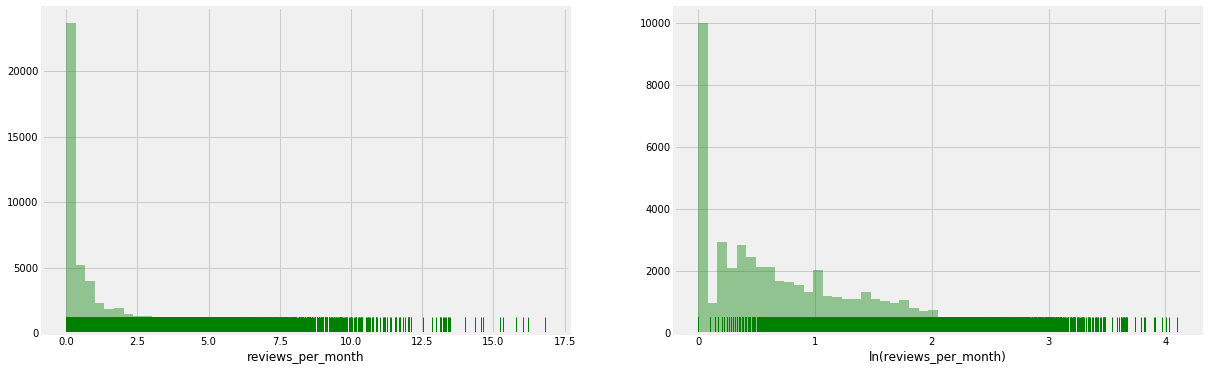

In [24]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

The distribution of the number of reviews per month is highly skewed however way we cut it. This is because there is a large weight on small numbers: there are a lot of properties which only get a few reviews and a rather fat tail of properties which get a lot of reviews. 

One explanation would be that the properties which are available a larger fraction of the year get more reviews. However, a scatter plot of reviews_per_month and availability_365 variables shows no evidence of a relationship so that explanation would appear to not be valid.

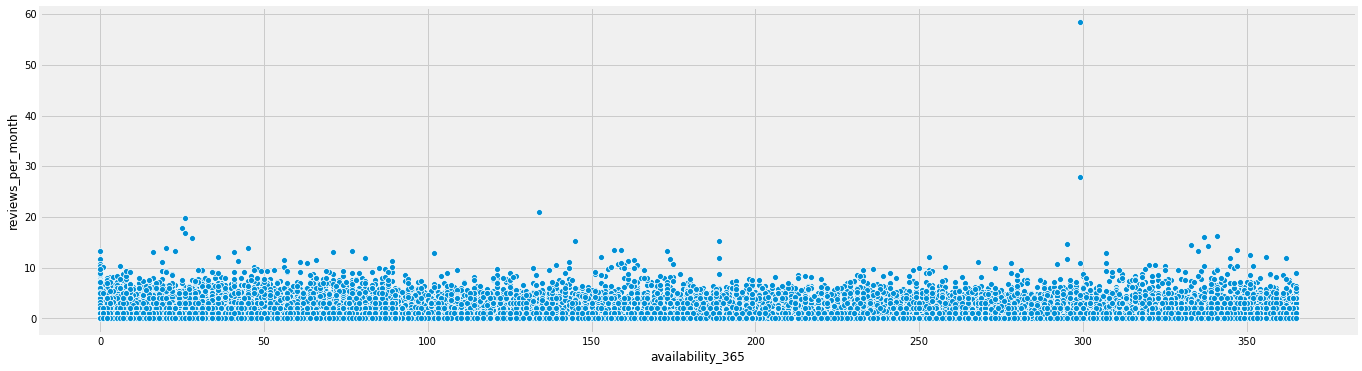

In [25]:
fig, axes = plt.subplots(1,1, figsize=(21,6))
sns.scatterplot(x= Combined_data['availability_365'], y=Combined_data['reviews_per_month'])

In [26]:
Combined_data['reviews_per_month'] = Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']

### 1.4.7 Availability_365

This distribution is highly skewed towards the low and high end. The dataset contains a hiuge number of properties that are available only for a couple of days each year, and a decent number that are available for > 300 days. 

(0, 365)

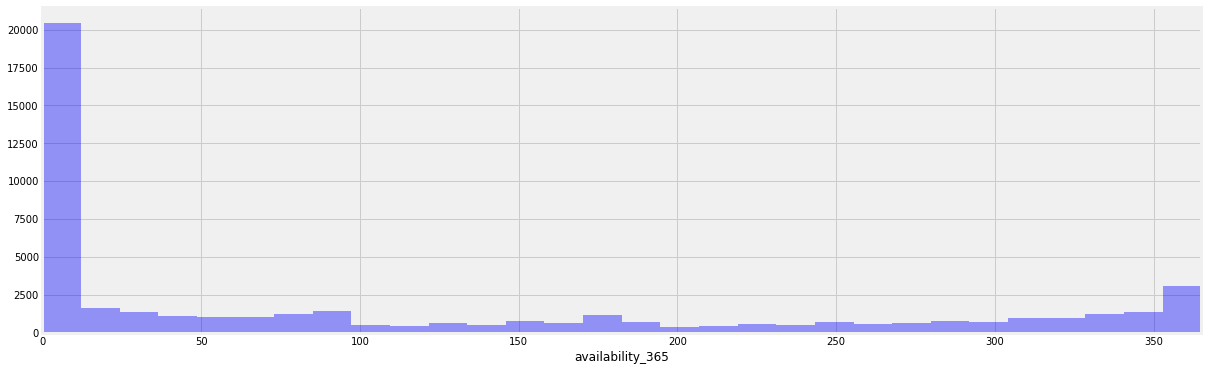

In [27]:
fig, axes = plt.subplots(1,1,figsize=(18.5, 6))
sns.distplot(Combined_data['availability_365'], rug=False, kde=False, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

### Feature engineering

In [28]:
Combined_data['all_year_avail'] = Combined_data['availability_365']>353
Combined_data['low_avail'] = Combined_data['availability_365']< 12
Combined_data['no_reviews'] = Combined_data['reviews_per_month']==0

## 1.5 Bivariate correlations

### 1.5.0 Pearson correlation matrix

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


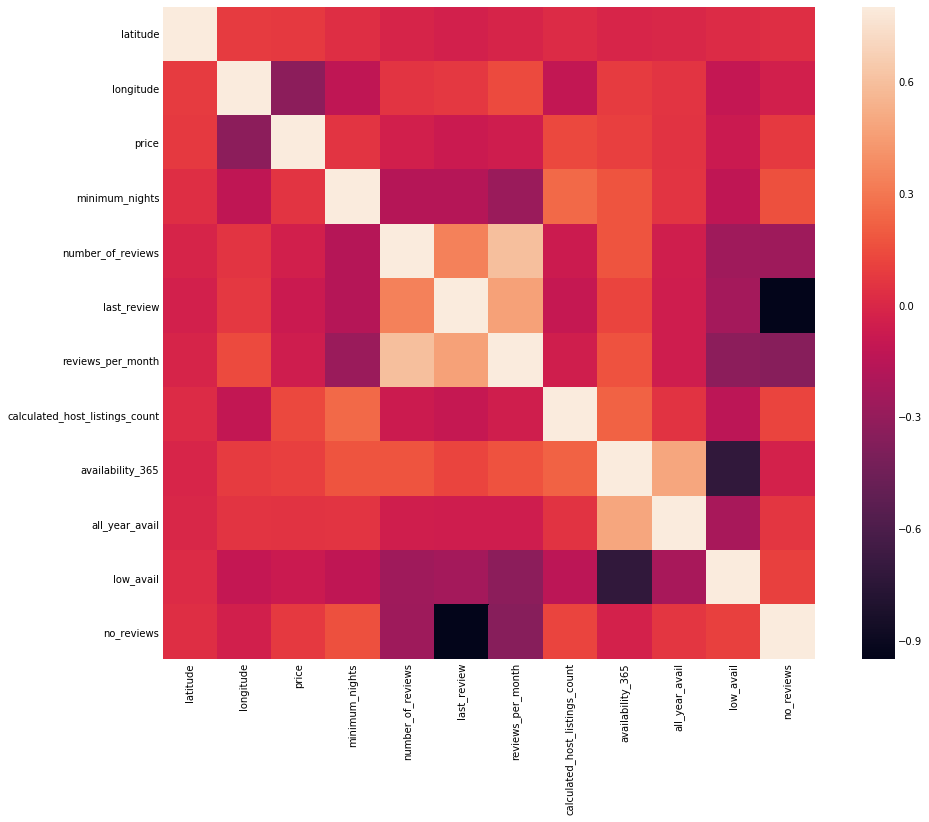

In [29]:
corrmatrix = Combined_data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

There don't appear to exist obvious, strong correlations between these variables. 

However, the number of reviews per month is fairly (40%) correlated with the total number of reviews and the the total number of reviews is correlated (at 30%) with the availability of the property. Both of these correlations make sense.

It's also interesting that the longitude is anticorrelated (at 20%) with the price. That also makes sense - property in the Bronx and in Queens is cheaper than Manhattan and Brooklyn.

### 1.5.1 PairPlot

In [30]:
# sns.pairplot(Combined_data.select_dtypes(exclude=['object']))

## 1.6 Encoding categorical features

In [31]:
categorical_features = Combined_data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48784, 3)


In [32]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   
3                          0                             1   
4                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   
3                              0                           0   
4                              1                           0   

   neighbourhood_group_Staten Island  neighbourhood_Allerton  \
0                                  0                       0   
1                                  0                       0   
2                                  0                       0   
3                                  0                       0   
4                                  0                       0   

   neighbourhood_Arden Heights  neighbourhood_Arrochar  neighbourhood_Arverne  \
0                            0                       0                      0   
1                            0                       0                      0   
2                            0                       0                      0   
3                            0                       0                      0   
4                            0                       0                      0   

   neighbourhood_Astoria  ...  neighbourhood_Williamsburg  \
0                      0  ...                           0   
1                      0  ...                           0   
2                      0  ...                           0   
3                      0  ...                           0   
4                      0  ...                           0   

   neighbourhood_Willowbrook  neighbourhood_Windsor Terrace  \
0                          0                              0   
1                          0                              0   
2                          0                              0   
3                          0                              0   
4                          0                              0   

   neighbourhood_Woodhaven  neighbourhood_Woodlawn  neighbourhood_Woodrow  \
0                        0                       0                      0   
1                        0                       0                      0   
2                        0                       0                      0   
3                        0                       0                      0   
4                        0                       0                      0   

   neighbourhood_Woodside  room_type_Entire home/apt  room_type_Private room  \
0                       0                          0                       1   
1                       0                          1                       0   
2                       0                          0                       1   
3                       0                          1                       0   
4                       0                          1                       0   

   room_type_Shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 229 columns]

In [33]:
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

## 1.7 Save transformed dataframe for future use

In [34]:
numerical_features =  Combined_data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (48784, 11)


In [35]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)
#print('Dimensions of the design matrix: {}'.format(X.shape))
#print('Dimension of the target vector: {}'.format(y.shape))

In [36]:
Processed_data = pd.concat([X_df, y], axis = 1)
Processed_data.to_csv('NYC_Airbnb_Processed.dat')

## 1.8 Train-test split

I'm going to split the data into a test set and a training set. I will hold out the test set until the very end and use the error on those data as an unbiased estimate of how my models did. 

I might perform a further split later on the training set into training set proper and a validation set or I might cross-validate.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39027, 240)
Dimensions of the training target vector: (39027,)
Dimensions of the test feature matrix: (9757, 240)
Dimensions of the test target vector: (9757,)


## 1.9 Rescale the design matrix

I now scale the design matrix with sklearn's RobustScaler() so that each predictor has zero mean and unit variance. This helps the convergence of machine learning algorithms such as linear regression.

I avoid data snooping by defining the scaleing transformation based on the training data not the test data.

In [39]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 2. Models

## 2.0 Cross-validation routine

I will score models based on K-fold cross-validation with 5 folds.

In [40]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

## 2.1 Scoring basic models (no parameter tuning)

In [41]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 139002199963511.00000 +/- 230896963741066.625000
Ridge: 0.19438 +/- 0.006210
Lasso: 0.45210 +/- 0.006634
ElasticNet: 0.45141 +/- 0.006620
RandomForestRegressor: 0.19279 +/- 0.005751
XGBRegressor: 0.18415 +/- 0.006391
HuberRegressor: 0.20359 +/- 0.008343


## 2.2 Ridge Regression

### 2.2.0 Hyperparameter optimization

I find the best value of the L2 penalty hyperparameter with a telescopic search based on cross-validation scores. I then train the Ridge model on the entire training set and test how it performs on the held-out test set.

In [42]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [43]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

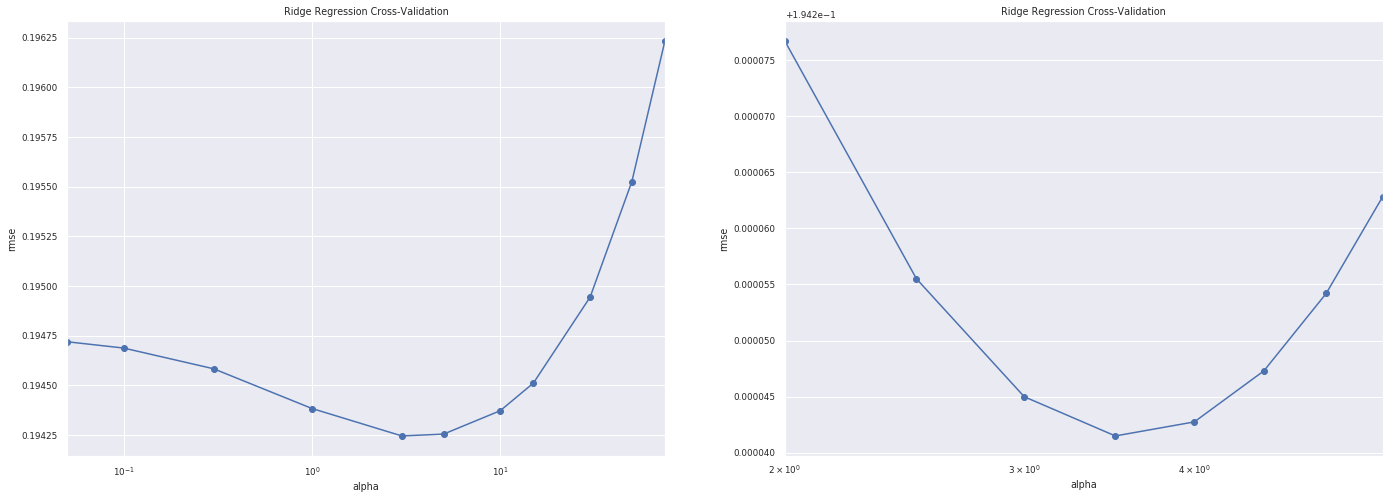

In [44]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) RR_best.fit(X_train, y_train) predicted_prices = RR_best.predict(test_data)



In [45]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas1,
        y= cv_ridge1,
        line = dict(color='royalBlue', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            )
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Telescopic Search: Coarse level', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [46]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas2,
        y= cv_ridge2,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Telescopic Search: Fine level', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

### 2.2.1 Best Ridge Regression model

In [47]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

algorithm  CV error    CV std  training error  test error  \
0  Ridge Regression  0.194241  0.006121        0.191407         0.0   

   training_r2_score  test_r2_score  
0           0.583508       0.573302

### 2.2.2 Interpretation of instance predictions with Lime

In [48]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_df.columns, class_names=['price'], verbose=True, mode='regression')

In [49]:
i=25
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X_df.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
#print(exp.intercept)
#print(exp.local_pred)
item.loc['predicted_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 3.835744492361726
Prediction_local [5.23348188]
Right: 5.40581291285614


0
latitude                          40.723540
longitude                        -73.982950
minimum_nights                     3.000000
number_of_reviews                 30.000000
last_review                     3003.000000
reviews_per_month                  0.280000
calculated_host_listings_count     1.000000
availability_365                 248.000000
neighbourhood_group_Manhattan      1.000000
neighbourhood_East Village         1.000000
room_type_Entire home/apt          1.000000
true_price                       196.000000
predicted_price                  187.444327

In [50]:
exp.show_in_notebook(show_table=True)

In [51]:
i=0
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X_df.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
#print(exp.intercept)
#print(exp.local_pred)
item.loc['predicted_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 4.878369614541148
Prediction_local [5.06501514]
Right: 4.651707191236776


0
latitude                         40.723320
longitude                       -73.979850
minimum_nights                    1.000000
calculated_host_listings_count    1.000000
low_avail                         1.000000
no_reviews                        1.000000
neighbourhood_group_Manhattan     1.000000
neighbourhood_East Village        1.000000
room_type_Private room            1.000000
true_price                       58.000000
predicted_price                 158.382841

In [52]:
exp.show_in_notebook(show_table=True)

In [53]:
i=78
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X_df.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
#print(exp.intercept)
#print(exp.local_pred)
item.loc['ridge_prediction_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 5.171239279741649
Prediction_local [5.09691562]
Right: 5.13294505595363


0
latitude                          40.72989
longitude                        -74.00541
minimum_nights                    30.00000
number_of_reviews                 16.00000
last_review                     2241.00000
reviews_per_month                  0.48000
calculated_host_listings_count     2.00000
low_avail                          1.00000
neighbourhood_group_Manhattan      1.00000
neighbourhood_West Village         1.00000
room_type_Entire home/apt          1.00000
true_price                       216.00000
ridge_prediction_price           163.51678

In [54]:
exp.show_in_notebook(show_table=True)

In [55]:
i=395
exp = explainer.explain_instance(X_test[i], RR.predict, num_features=5)
item = pd.DataFrame(scaler.inverse_transform(X_test[i].reshape(1,-1))[0], index=X_df.columns)
item.loc['minimum_nights'] = np.expm1(item.loc['minimum_nights'])
item.loc['true_price'] = np.exp(y_test.iloc[i])
#print(exp.intercept)
#print(exp.local_pred)
item.loc['ridge_prediction_price'] = np.exp(exp.local_pred)
item[(item.select_dtypes(include=['number']) != 0).any(1)]

Intercept 4.840097154339462
Prediction_local [4.79298146]
Right: 3.743346377729875


0
latitude                          40.705410
longitude                        -73.750370
minimum_nights                     2.000000
number_of_reviews                  7.000000
last_review                     2955.000000
reviews_per_month                  1.100000
calculated_host_listings_count     4.000000
availability_365                   6.000000
low_avail                          1.000000
neighbourhood_group_Queens         1.000000
neighbourhood_St. Albans           1.000000
room_type_Private room             1.000000
true_price                        31.000000
ridge_prediction_price           120.660578

In [56]:
exp.show_in_notebook(show_table=True)

### 2.2.3 Summary of local interpretation on test set

In [57]:
explainer_sh = shap.LinearExplainer(RR, X_train, feature_dependence='independent')
shap_values = explainer_sh.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_df.columns)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


## 2.3 LASSO Regression

### 2.3.0 Hyperparameter optimization

The training error for LASSO is somewhat higher than for Ridge (~0.198 vs ~0.197). However, the difference is quite small so that LASSO is still useful - for one as, a variable selector!

In [58]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

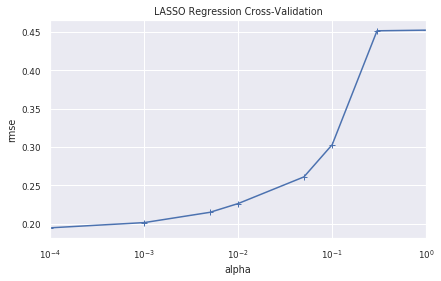

In [59]:
cv_lasso = pd.Series(cv_lasso, index = alphas) 
cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-+') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [60]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas,
        y= cv_lasso,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Lasso penalty optimization', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [61]:
best_alpha = alphas[np.argmin(cv_lasso.values)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': lasso_CV_best.mean(), 
            'CV std': lasso_CV_best.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

algorithm  CV error    CV std  training error  test error  \
0  LASSO Regression  0.194918  0.006204        0.193141    0.195115   

   training_r2_score  test_r2_score  
0           0.579736        0.57328

### 2.3.2 Variables selected

In [62]:
features = list(categorical_features_one_hot.columns) + list(numerical_features.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 108 variables and eliminated the other 132 variables


In [63]:
coef

neighbourhood_group_Bronx                  -0.020724
neighbourhood_group_Brooklyn               -0.086728
neighbourhood_group_Manhattan              -0.129359
neighbourhood_group_Queens                 -0.010678
neighbourhood_group_Staten Island          -0.003257
neighbourhood_Allerton                     -0.026425
neighbourhood_Arden Heights                -0.000124
neighbourhood_Arrochar                      0.075270
neighbourhood_Arverne                       0.160484
neighbourhood_Astoria                      -0.150610
neighbourhood_Bath Beach                    0.117940
neighbourhood_Battery Park City            -0.041432
neighbourhood_Bay Ridge                    -0.000000
neighbourhood_Bay Terrace                   0.415466
neighbourhood_Bay Terrace, Staten Island    0.115440
neighbourhood_Baychester                   -0.496201
neighbourhood_Bayside                       0.000000
neighbourhood_Bayswater                    -0.000000
neighbourhood_Bedford-Stuyvesant           -0.

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

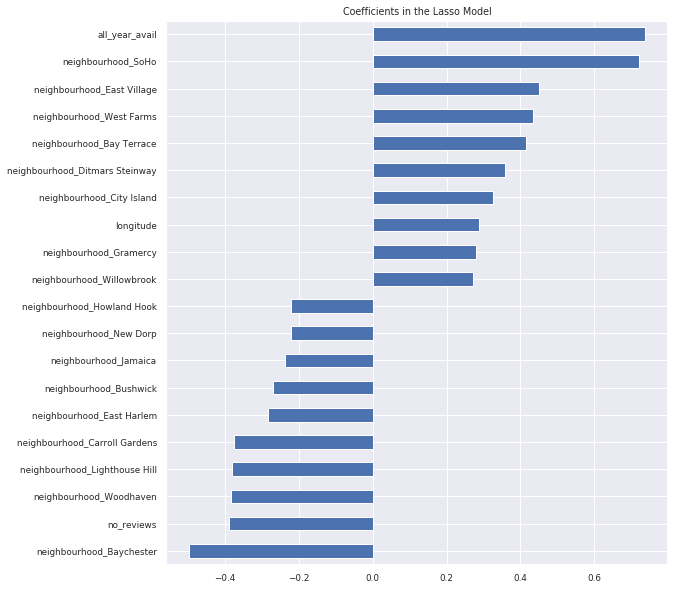

In [64]:
imp_coef = pd.concat([coef.sort_values().iloc[:10],
                     coef.sort_values().iloc[-10:]])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [65]:
i=25
exp = explainer.explain_instance(X_test[i], lasso.predict, num_features=5)

Intercept 4.444597291087881
Prediction_local [5.36335816]
Right: 5.410090952428852


In [66]:
exp.show_in_notebook(show_table=True)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


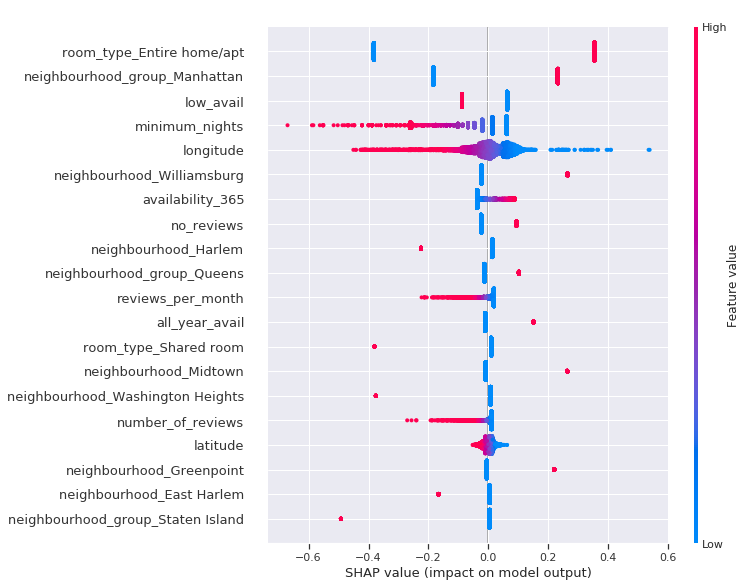

In [67]:
explainer = shap.LinearExplainer(lasso, X_train, feature_dependence='independent')
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_df.columns)

## 2.4 Huber regression

In [68]:
alphas = [0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1] 
#cv_huber = [-rmse_cv(HuberRegressor(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]
cv_huber = [0.20051906841425277, 0.20044833042114646, 0.20048899799050565, 0.200533996471012, 0.20051788009059482, 0.2005294886778608, 0.20052011204607623, 0.2004070661477452]

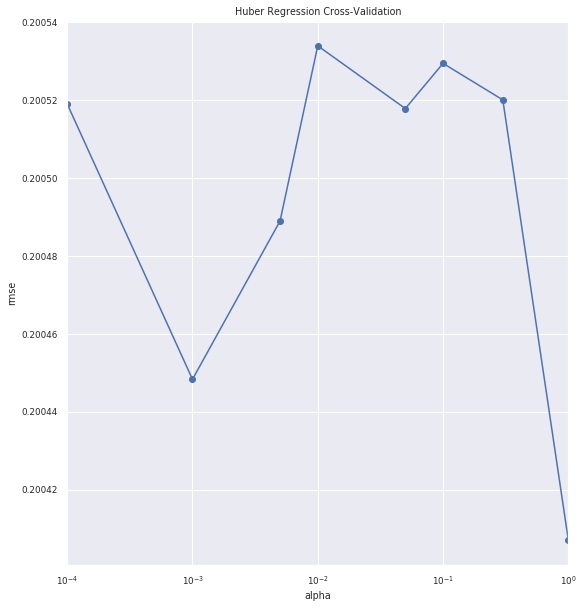

In [ ]:
cv_huber = pd.Series(cv_huber, index = alphas) 
cv_huber.plot(title = "Huber Regression Cross-Validation", style='-o') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas,
        y= cv_huber,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Lasso penalty optimization', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [ ]:
best_alpha = alphas[np.argmin(cv_huber.values)]
huber_CV_best = -rmse_cv(HuberRegressor(alpha=best_alpha))
huber = HuberRegressor(alpha=best_alpha)
huber.fit(X_train, y_train) 
y_train_huber = huber.predict(X_train)
y_test_huber = huber.predict(X_test)
huber_results = pd.DataFrame({'algorithm':['Huber Regression'],
            'CV error': huber_CV_best.mean(), 
            'CV std': huber_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_huber)],
            'test error': [mean_squared_error(y_test, y_test_huber)],
            'training_r2_score': [r2_score(y_train, y_train_huber)],
            'test_r2_score': [r2_score(y_test, y_test_huber)]})
huber_results

algorithm  CV error    CV std  training error  test error  \
0  Huber Regression  0.203737  0.007599        0.206178    0.205655   

   training_r2_score  test_r2_score  
0           0.551369       0.550229

## 2.5 Ridge with variables selected by LASSO

Something that people say one should try is rerunning algorithms on the feature subset selected by LASSO. 

On this dataset this doesn't seem to bring improvement: in the fact the values of the loss go up slighly for all algorithms or they don't change.

In [ ]:
lasso_coef = coef[coef!=0]
Xlv = X_df[list(lasso_coef.index)]
#X_lasso_vars.shape
Xlv_train, Xlv_test, y_train, y_test = train_test_split(Xlv, y, test_size=0.2, random_state=42)
print('Dimensions of the training feature matrix for lasso variable selection: {}'.format(Xlv_train.shape))
print('Dimensions of the test feature matrix for lasso variable selection: {}'.format(Xlv_test.shape))

Dimensions of the training feature matrix for lasso variable selection: (39027, 108)
Dimensions of the test feature matrix for lasso variable selection: (9757, 108)


In [ ]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_lv_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 3868874113799.37891 +/- 7737748227598.043945
Ridge: 0.35465 +/- 0.006059
Lasso: 0.45187 +/- 0.005497
ElasticNet: 0.45156 +/- 0.005454
RandomForestRegressor: 0.37337 +/- 0.005687
XGBRegressor: 0.18415 +/- 0.006391
HuberRegressor: 0.38662 +/- 0.006719


#### Ridge Regression Hyperparameter Optimization

In [ ]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [ ]:
alphas2 = [1.4+0.05*i for i in range(1,12)]
cv_ridge2 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

Text(0, 0.5, 'rmse')

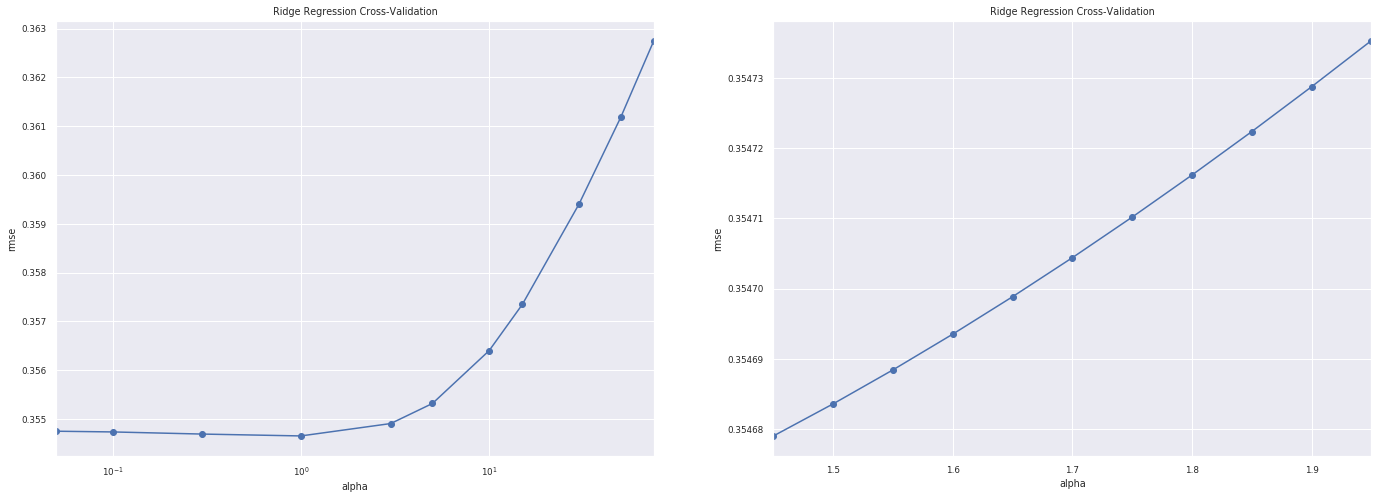

In [ ]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
#axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) RR_best.fit(X_train, y_train) predicted_prices = RR_best.predict(test_data)

In [ ]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_lassoVars_CV_best = -rmse_lv_cv(Ridge(alpha = best_alpha))
RR_lassoVars = Ridge(alpha = best_alpha) 
RR_lassoVars.fit(Xlv_train, y_train) 
y_train_RR_lassoVars = RR_lassoVars.predict(Xlv_train)
y_test_RR_lassoVars = RR_lassoVars.predict(Xlv_test)
ridge_lassoVars_results = pd.DataFrame({'algorithm':['Ridge Regression with LASSO variable selection'],
            'CV error': RR_lassoVars_CV_best.mean(), 
            'CV std': RR_lassoVars_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR_lassoVars)],
            'test error': [mean_squared_error(y_test, y_test_RR_lassoVars)],
            'training_r2_score': [r2_score(y_train, y_train_RR_lassoVars)],
            'test_r2_score': [r2_score(y_test, y_test_RR_lassoVars)]})

## 2.6 Random Forest Regressor

In [ ]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [ ]:
rfr_baseline_results

algorithm  CV error    CV std  training error  \
0  Random Forest Regressor [baseline]  0.192685  0.004604         0.03365   

   test error  
0    0.199813

We see that the training error is nearly an order of magnitude smaller than the test error, and the training error for any of the other algorithms. The baseline model is overfitting massively! Let's look at the baseline model's parameter values.

In [ ]:
print(rfr_baseline.estimators_)

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1608637542, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1273642419, splitter='best'), DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1935803228, splitter='best'), DecisionTreeRegressor(criterion='

#### Interpretation

In [ ]:
eli5.show_weights(rfr_baseline, feature_names=list(X_df.columns))

#### Hyperparameter tuning

In [ ]:
rf = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
#Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [ ]:
#best_random = rf_random.best_estimator_
best_random = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

In [ ]:
eli5.show_weights(best_random, feature_names=list(X_df.columns))

## 2.7 XGBoost Regressor

### 2.7.1 Baseline model (default parameters)

In [ ]:
xgb_baseline = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)
xgb_baseline_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_xgb_base, y_train)]})

Let's take a look at the settings and the results.

In [ ]:
print(xgb_baseline)
xgb_baseline_results


### 2.7.2 Learning rate optimization

In [ ]:
d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
for lr in [0.01, 0.05, 0.1, 0.5]:
    continue
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5)
    cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    xgb_model.fit(X_train, y_train)
    y_train_xgb = xgb_model.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    # makes no sense to look at max/min when we only have 3 CV folds
    #d['Max CV Error'].append(max(cv_res)
    #d['Min CV Error'].append(max(cv_res)
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

# to run the search, comment out 'continue' in the for loop
# here are the results I got
d = {'Learning Rate':[0.01, 0.05, 0.1, 0.5],
        'Mean CV Error': [0.184223, 0.177748, 0.175002, 0.188239],
        'CV Error Std': [0.00626211, 0.00575213, 0.00544426, 0.00525595],
        'Training Error': [0.179093, 0.164874, 0.154238, 0.109885]}

xgb_tuning_1 = pd.DataFrame(d)
xgb_tuning_1

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))

ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], color='red')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], 'o', color='black')
ax.fill_between(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'] - xgb_tuning_1['CV Error Std'], xgb_tuning_1['Mean CV Error'] + xgb_tuning_1['CV Error Std'], color='r', alpha=.1)
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], color='blue')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], 'o', color='black')
ax.legend(fontsize=12, loc = 'center right');
ax.set_ylim(0.1, 0.2)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Squared Error')
#ax.set_title('')

### 2.7.3 max_depth and min_child_weight optimization

In [ ]:
d = {'max_depth':[],
             'min_child_weight': [],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
xgbreg = XGBRegressor(n_estimators=2, learning_rate=0.05, early_stopping=5)
params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}
#print(params2)
#xgb_random.fit(X_train, y_train)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(X_train)
for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        continue
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=md, min_child_weight=mcw )
        cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        # makes no sense to look at max/min when we only have 3 CV folds
        #d['Max CV Error'].append(max(cv_res)
        #d['Min CV Error'].append(max(cv_res)
        d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

#print(d)

# to run the search, comment out 'continue' in the for loop
# here are the results I got

d = {'max_depth': [3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9], 'min_child_weight': [1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5], 
 'Mean CV Error': [0.1750024956601357, 0.17483011840929769, 0.17493846554576997, 0.17309889297300166, 0.17316622731288867, 
        0.17351576928079232, 0.17662213266155447, 0.17623539711716868, 0.17586167155362295, 0.18027062402369495, 0.1795815552171006, 0.1794402792605232], 
 'CV Error Std': [0.0054442612607845196, 0.005346726848155686, 0.005781224325978589, 0.0047992091315554805, 0.005078460548746871, 0.0055470435006580825, 
                  0.004522282538112627, 0.005521088520254507, 0.005182127039391581, 0.00548502303198156, 0.0056636180606624885, 0.005837983614899652],
 'Training Error': [0.15423828100740364, 0.1548338435116449, 0.15489721899341147, 0.1174713383813709, 0.11768836644071619, 0.11962286723882598, 
                    0.07157996439924702, 0.07249081997317249, 0.0809473890478948, 0.03364907441870936, 0.03787025803370217, 0.045449523400453724]}
        
xgb_tuning_2 = pd.DataFrame(d)
xgb_tuning_2

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

colors = ['orange','green','blue','red']

for i, md in enumerate(params2['max_depth']):
    color = colors[i]
    xgb_tuning_3 = xgb_tuning_2[xgb_tuning_2['max_depth']==md]
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], color=color, label= 'max_depth='+str(md))
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], 'o', color='black', label='_nolegend_')
    #ax.fill_between(xgb_tuning_3['Max_depth'], xgb_tuning_3['Mean CV Error'] - xgb_tuning_3['CV Error Std'], 
                    #xgb_tuning_3['Mean CV Error'] + xgb_tuning_3['CV Error Std'], color='r', alpha=.1, label='_nolegend_')
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], color=color, label='max_depth='+str(md))
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], 'o', color='black', label='_nolegend_')

for ax in axes:
    ax.set_xlabel('min_child_weight')
    ax.set_ylabel('Mean Squared Error')
    
axes[0].set_title('CV Error')
axes[1].set_title('Training Error')

axes[0].legend(fontsize=12, bbox_to_anchor=(0.6, .52, .7, .602), loc=3,);
axes[0].set_ylim([0.172, 0.181])

In [ ]:
print('Optimal parameter values are: ')
best = xgb_tuning_2.iloc[xgb_tuning_2.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

### 2.7.4 Best model

In [ ]:
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=5, min_child_weight=1 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

In [ ]:
eli5.show_weights(xgbreg_best, feature_names=list(X_df.columns))

# SUMMARY

In [ ]:
pd.concat([ridge_results, lasso_results, ridge_lassoVars_results, huber_results, rfr_best_results, xgb_best_results], axis=0, ignore_index=True)

# Acknowledgements

1. Penalized regression: https://www.kaggle.com/aaron7sun/you-got-this-feature-engineering-and-lasso
2. Hyperparameter tuning for random forests: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

### Model interpretability

1. Kevin Lemagnen's 2018 NYC PyData talk: [Open the Black Box: an Introduction to Model Interpretability with LIME and SHAP](https://www.youtube.com/watch?v=C80SQe16Rao)
2. Lime Regression example can be found in [this notebook](https://marcotcr.github.io/lime/tutorials/Using%2Blime%2Bfor%2Bregression.html)
3. [The original SHAP paper](https://arxiv.org/abs/1705.07874) is quite readable